In [85]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL
import cv2
import glob
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os

### Use Keras Model Architecture 

In [86]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers
from keras.optimizers import SGD,Adam
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf

In [87]:
from sklearn.model_selection import KFold

### Dataset Preparation 

In [133]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [134]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [135]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [137]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [138]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [139]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [140]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [141]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [142]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [143]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

<AxesSubplot:>

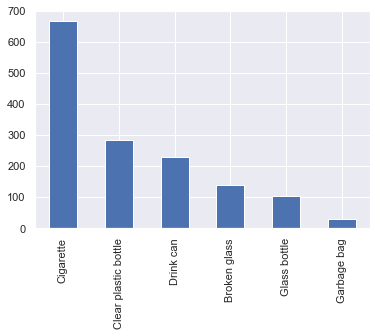

In [148]:
df['category'].value_counts().plot.bar()

In [145]:
df['category'].value_counts()

Cigarette               667
Clear plastic bottle    285
Drink can               229
Broken glass            138
Glass bottle            104
Garbage bag              31
Name: category, dtype: int64

### Fetch, crop and store image data

In [146]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

In [147]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

KeyboardInterrupt: 

In [21]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)

In [22]:
df.head()

,filename,category
0,batch_1/000010.jpg,Clear plastic bottle
1,batch_1/000019.jpg,Clear plastic bottle
2,batch_1/000019.jpg,Clear plastic bottle
3,batch_1/000001.jpg,Clear plastic bottle
4,batch_1/000005.jpg,Clear plastic bottle


In [23]:
df1 = pd.get_dummies(df, columns=["category"])
df1.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Paper cup,category_Unlabeled litter
0,batch_1/000010.jpg,0,1,0,0,0
1,batch_1/000019.jpg,0,1,0,0,0
2,batch_1/000019.jpg,0,1,0,0,0
3,batch_1/000001.jpg,0,1,0,0,0
4,batch_1/000005.jpg,0,1,0,0,0


In [24]:
# 
y = np.array(df1.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1765, 5)
(1765, 128, 128, 3)


### Data Split 

In [69]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Build Model using k-fold technique

In [80]:
num_folds = 10
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 128, 128, 3
loss_function = categorical_crossentropy
no_classes = 5
no_epochs = 100
optimizer = Adam()
verbosity = 0
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

In [81]:
# Normalize data
input_train = X_train / 255
input_test = X_test / 255

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [82]:
# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [83]:
print(inputs.shape)
print(targets.shape)

(1765, 128, 128, 3)
(1765, 5)


In [79]:

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.3859135660074524; accuracy of 54.23728823661804%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.356912359679486; accuracy of 48.58756959438324%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1.2717786616524733; accuracy of 37.288135290145874%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1.4675128621570135; accuracy of 38.41807842254639%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1.3910166052101696; accuracy of 44.632768630981445%
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 1.3915